In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline



X_train = pd.read_csv("../Data/Processed/X_train.csv")
X_test  = pd.read_csv("../Data/Processed/X_test.csv")
y_train = pd.read_csv("../Data/Processed/y_train.csv").squeeze()
y_test  = pd.read_csv("../Data/Processed/y_test.csv").squeeze()

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)
print("\nClass distribution in y_train:")
print(y_train.value_counts(normalize=True))



# evaluation function

def evaluate_model(model, X_train, y_train, X_test, y_test, name="Model"):
    """
    Fit model, print confusion matrix, accuracy, precision, recall, F1, ROC-AUC,
    and full classification report.
    """
 
    print(f"Evaluating: {name}")


 
    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)

    # Probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        auc = None

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:")
    print(cm)
    print()

    # Basic metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    if auc is not None:
        print(f"ROC-AUC  : {auc:.3f}")
    print()

    # Full classification report (per-class metrics)
    print("Classification report:")
    print(classification_report(y_test, y_pred, digits=3))
    print("\n\n")



# KNN with Euclidean + SMOTE + uniform weights (k = 5)

knn_uniform = ImbPipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("knn", KNeighborsClassifier(
        n_neighbors=5,
        weights="uniform",      # all neighbors equal
        metric="euclidean"      
    ))
])

evaluate_model(
    knn_uniform,
    X_train, y_train,
    X_test, y_test,
    name="KNN + SMOTE + Euclidean + UNIFORM weights (k=5)"
)



# KNN with Euclidean + SMOTE + distance weights (k = 5)

knn_distance = ImbPipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("knn", KNeighborsClassifier(
        n_neighbors=5,
        weights="distance",   
        metric="euclidean"
    ))
])

evaluate_model(
    knn_distance,
    X_train, y_train,
    X_test, y_test,
    name="KNN + SMOTE + Euclidean + DISTANCE weights (k=5)"
)



# Grid search over different k and weights with precision, recall, F1 as scoring metrics


knn_pipe = ImbPipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("knn", KNeighborsClassifier(metric="euclidean"))
])

# Values of k and weights we want to test
param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11],
    "knn__weights": ["uniform", "distance"],
}

# Stratified K-Fold (preserves class ratio in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Multiple scoring metrics
scoring = {
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

grid = GridSearchCV(
    estimator=knn_pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit="f1",  
    cv=cv,
    n_jobs=-1,
    verbose=2
)

print("Running grid search for KNN now")
grid.fit(X_train, y_train)

best_params = grid.best_params_
best_index = grid.best_index_

best_f1 = grid.cv_results_["mean_test_f1"][best_index]
best_precision = grid.cv_results_["mean_test_precision"][best_index]
best_recall = grid.cv_results_["mean_test_recall"][best_index]

print("GRID SEARCH RESULTS ")
print("Best Parameters:", best_params)
print(f"Best CV F1 score       : {best_f1:.3f}")
print(f"Best CV Precision score: {best_precision:.3f}")
print(f"Best CV Recall score   : {best_recall:.3f}")


best_knn = grid.best_estimator_



# Evaluate the more suitable KNN model on the test set

evaluate_model(
    best_knn,
    X_train, y_train,
    X_test, y_test,
    name=f"Best KNN from GridSearch (k={best_params['knn__n_neighbors']}, "
         f"weights={best_params['knn__weights']})"
)

Train shape: (9864, 58)
Test shape : (2466, 58)

Class distribution in y_train:
Revenue
False    0.845296
True     0.154704
Name: proportion, dtype: float64
Evaluating: KNN + SMOTE + Euclidean + UNIFORM weights (k=5)
Confusion matrix:
[[1366  718]
 [ 204  178]]

Accuracy : 0.626
Precision: 0.199
Recall   : 0.466
F1-score : 0.279
ROC-AUC  : 0.587

Classification report:
              precision    recall  f1-score   support

       False      0.870     0.655     0.748      2084
        True      0.199     0.466     0.279       382

    accuracy                          0.626      2466
   macro avg      0.534     0.561     0.513      2466
weighted avg      0.766     0.626     0.675      2466




Evaluating: KNN + SMOTE + Euclidean + DISTANCE weights (k=5)
Confusion matrix:
[[1394  690]
 [ 213  169]]

Accuracy : 0.634
Precision: 0.197
Recall   : 0.442
F1-score : 0.272
ROC-AUC  : 0.582

Classification report:
              precision    recall  f1-score   support

       False      0.867    

In [11]:

# Evaluation function 

def evaluate_model(model, X_train, y_train, X_test, y_test, name="Model"):
 
    print(f"Evaluating: {name}")
   

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        auc = None

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:")
    print(cm)
    print()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    if auc is not None:
        print(f"ROC-AUC  : {auc:.3f}")
    print()

    print("Classification report:")
    print(classification_report(y_test, y_pred, digits=3))
    print("\n\n")



#  KNN + SMOTE + Manhattan + UNIFORM weights (k=5)

knn_manhattan_uniform = ImbPipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("knn", KNeighborsClassifier(
        n_neighbors=5,
        weights="uniform",
        metric="manhattan"
    ))
])

evaluate_model(
    knn_manhattan_uniform,
    X_train, y_train,
    X_test, y_test,
    name="KNN + SMOTE + Manhattan + UNIFORM weights (k=5)"
)



# KNN + SMOTE + Manhattan + DISTANCE weights (k=5)

knn_manhattan_distance = ImbPipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("knn", KNeighborsClassifier(
        n_neighbors=5,
        weights="distance",
        metric="manhattan"
    ))
])

evaluate_model(
    knn_manhattan_distance,
    X_train, y_train,
    X_test, y_test,
    name="KNN + SMOTE + Manhattan + DISTANCE weights (k=5)"
)



# Grid Search for Manhattan Distance KNN

knn_pipe_manhattan = ImbPipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("knn", KNeighborsClassifier(metric="manhattan"))
])

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11],
    "knn__weights": ["uniform", "distance"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

grid_manhattan = GridSearchCV(
    estimator=knn_pipe_manhattan,
    param_grid=param_grid,
    scoring=scoring,
    refit="recall",          
    cv=cv,
    n_jobs=-1,
    verbose=2
)

print("Running Manhattan KNN grid search now")
grid_manhattan.fit(X_train, y_train)

best_params = grid_manhattan.best_params_
best_idx = grid_manhattan.best_index_

best_f1 = grid_manhattan.cv_results_["mean_test_f1"][best_idx]
best_prec = grid_manhattan.cv_results_["mean_test_precision"][best_idx]
best_recall = grid_manhattan.cv_results_["mean_test_recall"][best_idx]

print("GRID SEARCH RESULTS (Manhattan)")
print("Best Parameters:", best_params)
print(f"Best CV Recall        : {best_recall:.3f}")
print(f"Best CV Precision     : {best_prec:.3f}")
print(f"Best CV F1            : {best_f1:.3f}")


best_knn_manhattan = grid_manhattan.best_estimator_



#  Evaluate the best Manhattan KNN model
evaluate_model(
    best_knn_manhattan,
    X_train, y_train,
    X_test, y_test,
    name=f"Best KNN Manhattan (k={best_params['knn__n_neighbors']}, weights={best_params['knn__weights']})"
)


Evaluating: KNN + SMOTE + Manhattan + UNIFORM weights (k=5)
Confusion matrix:
[[1450  634]
 [ 215  167]]

Accuracy : 0.656
Precision: 0.208
Recall   : 0.437
F1-score : 0.282
ROC-AUC  : 0.604

Classification report:
              precision    recall  f1-score   support

       False      0.871     0.696     0.774      2084
        True      0.208     0.437     0.282       382

    accuracy                          0.656      2466
   macro avg      0.540     0.566     0.528      2466
weighted avg      0.768     0.656     0.697      2466




Evaluating: KNN + SMOTE + Manhattan + DISTANCE weights (k=5)
Confusion matrix:
[[1470  614]
 [ 223  159]]

Accuracy : 0.661
Precision: 0.206
Recall   : 0.416
F1-score : 0.275
ROC-AUC  : 0.598

Classification report:
              precision    recall  f1-score   support

       False      0.868     0.705     0.778      2084
        True      0.206     0.416     0.275       382

    accuracy                          0.661      2466
   macro avg      0.5

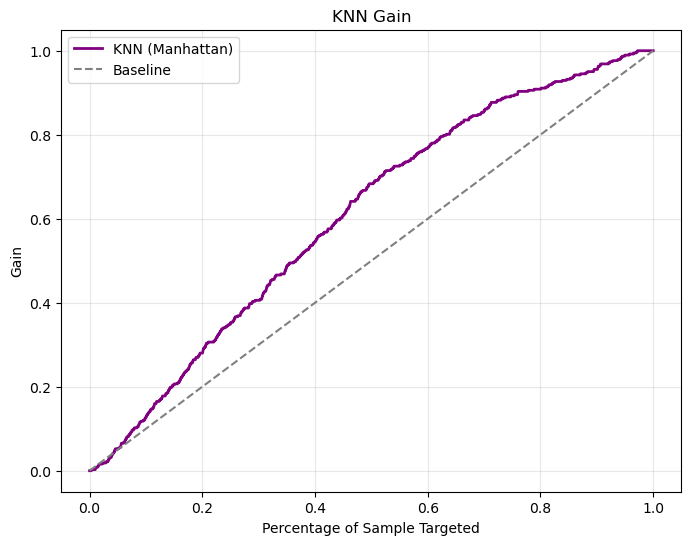

Exception ignored in: <function ResourceTracker.__del__ at 0x1025b0cc0>
Traceback (most recent call last):
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1076d0cc0>
Traceback (most recent call last):
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exceptio

In [ ]:
y_proba = best_knn_manhattan.predict_proba(X_test)[:, 1]

sorted_indices = np.argsort(y_proba)[::-1]
y_test_sorted = np.array(y_test)[sorted_indices]

gain = np.cumsum(y_test_sorted) / np.sum(y_test_sorted)
percentages = np.arange(1, len(gain) + 1) / len(gain)

gain = np.insert(gain, 0, 0)
percentages = np.insert(percentages, 0, 0)

plt.figure(figsize=(8, 6))
plt.plot(percentages, gain, label='KNN (Manhattan)', color='purple', lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="grey", label='Baseline')

plt.title("KNN Gain")
plt.xlabel("Percentage of Sample Targeted")
plt.ylabel("Gain")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()